# CNN with EfficientNet and transfer learning of pretrained weights

Goals in this notebook:
- Training dataset on a configuration of CNN using EfficientNet. This pipe will be built for subset of 1912 images first (balanced dataset), but will later be applied to our real training dataset (also balanced).
    - we'll make a fixed number of end layers trainable; the rest of parameters in the front layers will be frozen.
- High-level comparison of different EfficientNets and weights on validation metrics.
- On the best EfficientNet, do some hyperparmater tuning using `optuna` on post-transfer-learning dense layers, optimizing for AUC
    - Maybe also hyperparameter tune the # of layers in EfficientNet that's made trainable?


In [ ]:
!pip install optuna
!pip install tensorflow-addons

In [4]:
import joblib
import time

import tensorflow as tf
import tensorflow_addons as tfa
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as sklearn_metrics

import constants
import lesion_data

## Load dataset

Here, I'm using a subbset of training data, which is a balanced dataset of all 8 classes, with 239 images each. I won't be using validation data yet (TBD).

In [5]:
random_seed = 21

train_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_training_augmented_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_validation_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

Found 16005 files belonging to 8 classes.
Found 2028 files belonging to 8 classes.


#### Choosing the same metrics for evaluation

In [6]:
tf.keras.backend.clear_session()
metrics = [
    "accuracy",
    tf.metrics.Precision(name="precision"),
    tf.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(curve="PR", name="auc_pr"),
    tf.keras.metrics.AUC(curve="ROC", name="auc_roc"),
    tfa.metrics.F1Score(num_classes=8, name="f1_score"),
]

# For quality of life
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        mark = "*"
        if epoch % 10 == 9:
            mark = "*|"
        print(mark, end="")

        with open("progress_log.txt", "a") as logf:
            logf.write(f"{time.time()} Done training on {epoch=}, {logs=}\n")


def plot_history_df(history_df: pd.DataFrame):
    x_arr = np.arange(len(history_df['loss'])) + 1

    fig = plt.figure(figsize=(18, 9))
    for i, metric in enumerate(["loss", "accuracy", "precision", "recall", "auc_pr", "auc_roc"]):
        ax = fig.add_subplot(2, 3, i+1)
        ax.plot(x_arr, history_df[metric], '-', label=f'Train {metric}')
        ax.plot(x_arr, history_df[f'val_{metric}'], '--', label=f'Validation {metric}')
        ax.legend(fontsize=10)
        ax.set_xlabel('Epoch', size=15)
        ax.set_ylabel(metric, size=15)

## Building model

The EfficientNet-based CNN model will have the following elements:

1. EfficientNet -- first need to figure out which one
    1. _**A**_: trainable parameters, increment of 500,000
1. _**G**_ layers of Dense (choose between 0 and 4 layers; another `Sequential`)
    1. _**H**_ units (choose 5 to 30)
    1. Activation: relu
    1. Dropout - 0.1
1. One output layer of Dense
    1. output units: 8
    1. Activation: softmax
    
Next, I'll build a simple version of EfficientNet model, just to get a feel for how to set it up. According to [this guide from Keras](https://keras.io/guides/transfer_learning/), we should develop our top layer (Dense layers after pretrained layer) first while keeping pretrained weights frozen. After that's done, only then we unfreeze all or some of the weights in the pretrained layer at a _small learning rate_ for fine-tuning.

In [11]:
IMG_SHAPE = (224, 224, 3)

# light augmentation on balanced data
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.5),
    ]
)

tf.keras.backend.clear_session()
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB0(
    weights="imagenet",
    pooling="max",
    include_top=False,
)

# Making all of it not trainable
efficientnet_model.trainable = False


total_dense_layers = 2
dense_units = 10

dropout_rate = 0.2

dense_layers = tf.keras.models.Sequential(name="dense_layers")
for dense_layer_num in range(total_dense_layers):
    dense_layers.add(
        tf.keras.layers.Dense(
            dense_units,
            activation="relu",
            name=f"Dense_{dense_layer_num}",
        )
    )
    dense_layers.add(
        tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
    )
    dense_layers.add(
        tf.keras.layers.BatchNormalization()
    )

# putting it altogether
inputs = tf.keras.Input(shape=IMG_SHAPE)

x = data_augmentation(inputs)
x = efficientnet_model(x) # EfficientNet with ImageNet weights
x = dense_layers(x) # Dense layers

outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_layers (Sequential)    (None, 10)                13000     
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 4,062,659
Trainable params: 13,048
Non-trainable params: 4,049,611
_________________________________________________________________


In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

In [14]:
# Fit it
callbacks = [CustomCallback(), tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=20, mode='max')]
tf.keras.backend.clear_session()
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
history = model.fit(
    train_ds,
    validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=0,
)
print("\ndone training")

grand_history = history.history

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-12-06 00:11:59.563 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:4835 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-06 00:11:59.591 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:4835 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
**********|**********|**********|**********|********
done training


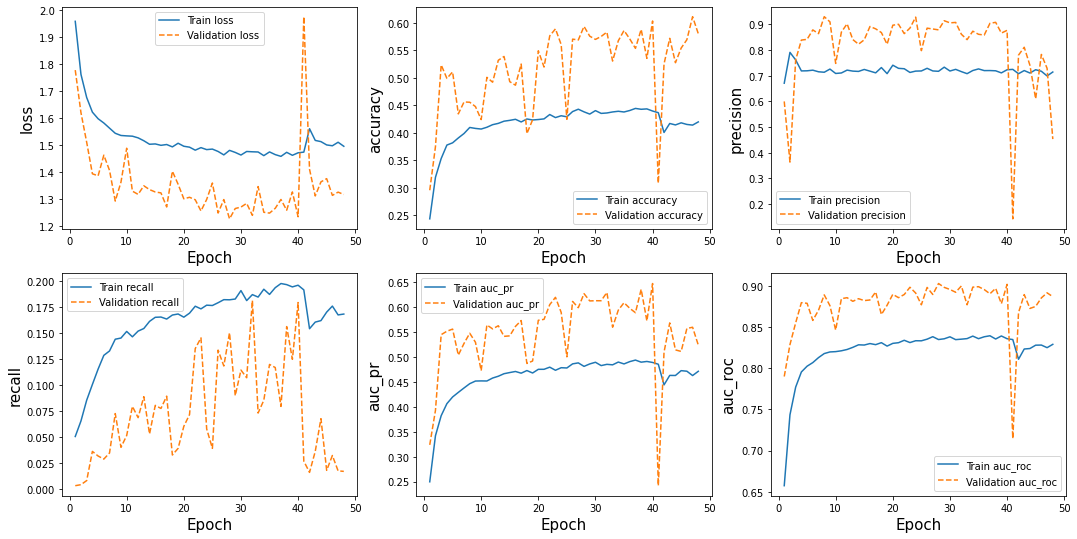

In [15]:
# View history
plot_history_df(pd.DataFrame(history.history))

In [16]:
history_df = pd.DataFrame(grand_history)
history_df.to_csv("saved_models/cnn_efficientnet/efficientnet0_16k_modified_model_history.csv")
model.save("saved_models/cnn_efficientnet/efficientnet0_16k_modified_model.h5")

/usr/local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


#### Fine-tuning

Now once we have our dense layer trained, we proceed to fine-tuning of EfficientNet. We'll need to now use a very low learning rate in our compiler.

In [17]:
# Making the last 1 million parameters trainable; others frozen/not trainable
efficientnet_model.trainable = True

target_trainable_params = 2e6  # arbitrary
trainable_params_left = target_trainable_params
for layer in reversed(efficientnet_model.layers):  # Go from bottom
    if trainable_params_left > 0:
        trainable_params_left -= layer.count_params()
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense_layers (Sequential)    (None, 10)                13000     
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 4,062,659
Trainable params: 2,008,408
Non-trainable params: 2,054,251
_________________________________________________________________


In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    metrics=metrics,
)

In [ ]:
# Fit it
callbacks = [
    CustomCallback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=50, mode='max'),
]
tf.keras.backend.clear_session()
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
history_finetune = model.fit(
    train_ds,
    validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0,
)
print("done training")

**|**********|*****|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|done training


In [21]:
combined_history = grand_history.copy()
for m in combined_history.keys():
    combined_history[m] += history_finetune.history[m]

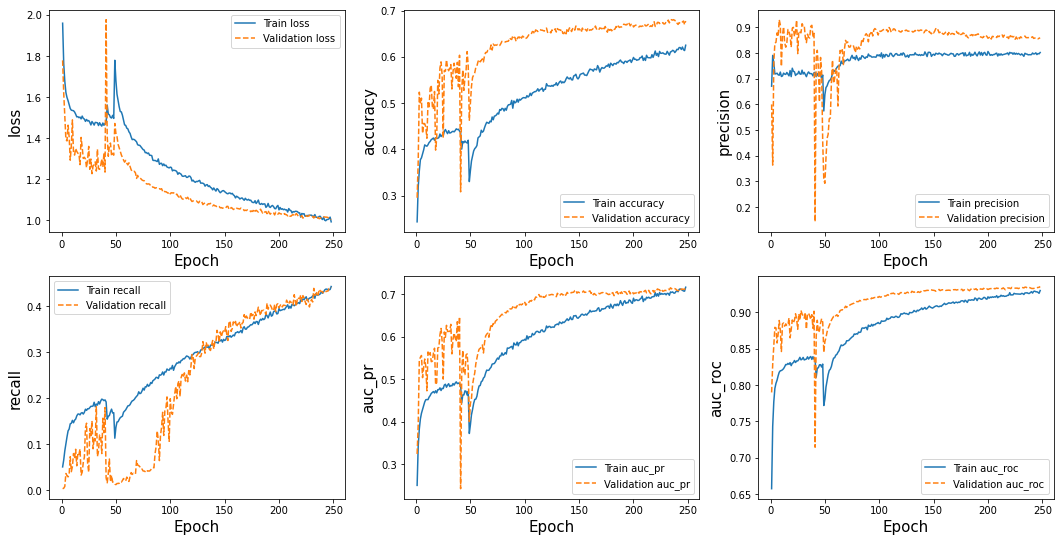

In [22]:
history_df = pd.DataFrame(combined_history)
plot_history_df(combined_history)

In [25]:
# Try saving model
model.save("saved_models/cnn_efficientnet/efficientnet0_16k_modified_model.h5")

/usr/local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [23]:
pd.DataFrame(combined_history).to_csv("saved_models/cnn_efficientnet/efficientnet0_16k_modified_model_history.csv")

In [24]:
grand_history_df = pd.read_csv("saved_models/cnn_efficientnet/efficientnet0_16k_modified_model_history.csv")
# View final epoch metrics
grand_history_df.tail(1)

,Unnamed: 0,loss,accuracy,precision,recall,auc_pr,auc_roc,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_auc_pr,val_auc_roc,val_f1_score
247,247,0.993114,0.62518,0.802355,0.442862,0.716676,0.930023,[0.62177026 0.63895756 0.47983453 0.81754875 0...,1.003978,0.677515,0.859615,0.440828,0.718323,0.935537,[0.4173913 0.7081174 0.51898736 0.44444448 0...


In [85]:
!ls saved_models/cnn_efficientnet -lah

total 84M
drwxr-xr-x 3 root root 6.0K Nov 18 09:00 .
drwxr-xr-x 5 root root 6.0K Nov 14 01:04 ..
drwxr-xr-x 2 root root 6.0K Nov 14 02:55 .ipynb_checkpoints
-rw-r--r-- 1 root root  25M Nov 14 01:44 best_en_model.h5
-rw-r--r-- 1 root root 4.8K Nov 14 03:42 best_en_model_history.csv
-rw-r--r-- 1 root root  28M Nov 14 03:48 best_en_tuned_model.h5
-rw-r--r-- 1 root root 7.2K Nov 14 03:48 best_en_tuned_model_history.csv
-rw-r--r-- 1 root root  32M Nov 18 09:00 efficientnet0_model.h5
-rw-r--r-- 1 root root  15K Nov 14 03:55 no-name-431d0280-4cde-4f72-9cf5-47cf18d215eb.pkl


^ The model size is quite big. Let's be careful about what model to save and what to commit to git.

## Comparison between various versions of EfficientNet



In [ ]:
IMG_SHAPE = (224, 224, 3)

verbose=False
best_model = None
best_auc = -1

for en_model_class in [
    tf.keras.applications.efficientnet.EfficientNetB0,
    tf.keras.applications.efficientnet.EfficientNetB1,
    tf.keras.applications.efficientnet.EfficientNetB2,
    tf.keras.applications.efficientnet.EfficientNetB3,
    tf.keras.applications.efficientnet.EfficientNetB4,
    tf.keras.applications.efficientnet.EfficientNetB5,
    tf.keras.applications.efficientnet.EfficientNetB6,
    tf.keras.applications.efficientnet.EfficientNetB7,
]:
    tf.keras.backend.clear_session()
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    
    efficientnet_model = en_model_class(
        weights="imagenet",
        pooling="max",
        include_top=False,
    )
    
    # Freezing the pre-trained model first in comparisons
    efficientnet_model.trainable = False

    # # Making the last 1 million parameters trainable; others frozen/not trainable
    # target_trainable_params = 1e6  # arbitrary
    # trainable_params_left = target_trainable_params
    # for layer in reversed(efficientnet_model.layers):  # Go from bottom
    #     if trainable_params_left > 0:
    #         trainable_params_left -= layer.count_params()
    #         layer.trainable = True
    #     else:
    #         layer.trainable = False

    total_dense_layers = 2
    dense_units = 10

    dropout_rate = 0.1

    dense_layers = tf.keras.models.Sequential(name="dense_layers")
    for dense_layer_num in range(total_dense_layers):
        dense_layers.add(
            tf.keras.layers.Dense(
                dense_units,
                activation="relu",
                name=f"Dense_{dense_layer_num}",
            )
        )
        dense_layers.add(
            tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
        )
        dense_layers.add(
            tf.keras.layers.BatchNormalization()
        )

    # putting it altogether
    inputs = tf.keras.Input(shape=IMG_SHAPE)

    x = efficientnet_model(inputs) # EfficientNet with ImageNet weights
    x = dense_layers(x) # Dense layers

    outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer="adam",
        metrics=metrics,
    )
    
    # Fit
    callbacks = [CustomCallback(), tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=50, mode='max')]  # stop when not improving
    history = model.fit(
        train_ds,
        validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
        epochs=200,
        batch_size=32,
        callbacks=callbacks,
        verbose=int(verbose),
    )
    last_auc = history.history["val_auc_roc"][-1]
    
    # Print results
    print(
        f"Completed training on {en_model_class.__name__}, "
        + f"total {len(history.history['loss'])} epochs, "
        + f"val_auc_roc: {last_auc:.4f}"
    )
    # Save history regardless if it's good
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(f"saved_models/cnn_efficientnet/discovery_{en_model_class.__name__}_16k_history.csv")
    
    # Save model if it's the best
    if last_auc > best_auc:
        best_auc = last_auc
        if verbose:
            print(f"New {best_auc=}")
        best_model = model
        best_model.save("saved_models/cnn_efficientnet/best_en_16k_model.h5")
        history_df.to_csv("saved_models/cnn_efficientnet/best_en_16k_model_history.csv")


**********|**********|**********|**********|**********|**********|**********|**********|**Completed training on EfficientNetB0, total 82 epochs, val_auc_roc: 0.9013
**********|**********|**********|**********|**********|**********|**Completed training on EfficientNetB1, total 62 epochs, val_auc_roc: 0.8774
**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|*******Completed training on EfficientNetB2, total 157 epochs, val_auc_roc: 0.8497
**********|**********|**********|**********|**********|**********|**********|**********|*****Completed training on EfficientNetB3, total 85 epochs, val_auc_roc: 0.9167
**********|**********|**********|**********|**********|**********|**********|**********|****Completed training on EfficientNetB4, total 84 epochs, val_auc_roc: 0.8955
**********|**********|**********|**********|**********|**********|**********|******Completed training on Effi

In [7]:
# Load saved best model
best_model = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_16k_model.h5")

In [8]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_layers (Sequential)    (None, 10)                15560     
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 10,799,183
Trainable params: 15,608
Non-trainable params: 10,783,575
_________________________________________________________________


In [9]:
best_model.layers[1].name

'efficientnetb3'

Evaluation of training

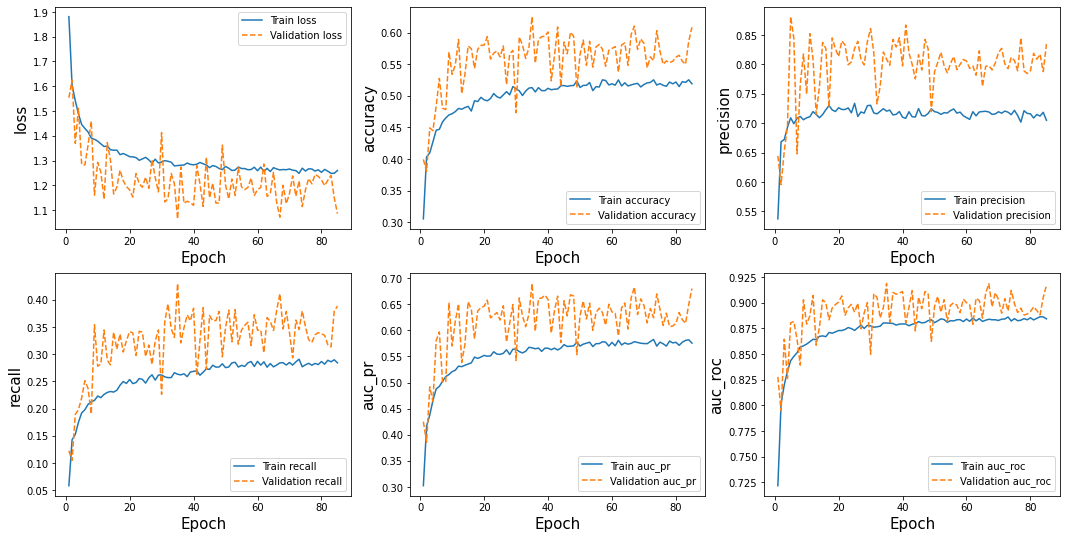

In [11]:
hist = pd.read_csv("saved_models/cnn_efficientnet/discovery_EfficientNetB3_16k_history.csv")
plot_history_df(hist)

## Using [optuna](https://optuna.org/) for hyperparameter tuning

We will set up the model as something that can be manipulated by optuna, then some trials to figure out the best hyperparameters on our dataset.

In [ ]:
# Parameterize our entire model
verbose=False
IMG_SHAPE = (224, 224, 3)

best_model = None
best_auc = -1

def build_and_compile_model_optuna(trial):
    
    tf.keras.backend.clear_session()
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    
    # EfficientNet
    en_model_class = tf.keras.applications.efficientnet.EfficientNetB3  # Change this to whichever that is best
    efficientnet_model = en_model_class(
        weights="imagenet",
        pooling="max",
        include_top=False,
    )
    
    # Freezing the pre-trained model first in comparisons
    efficientnet_model.trainable = False

    # # Making the last X parameters trainable; others frozen/not trainable
    # target_trainable_params = trial.suggest_int("trainable_params_increment", 2, 5) * 5e5  # increments of 500,000
    # trainable_params_left = target_trainable_params
    # for layer in reversed(efficientnet_model.layers):  # Go from bottom
    #     if trainable_params_left > 0:
    #         trainable_params_left -= layer.count_params()
    #         layer.trainable = True
    #     else:
    #         layer.trainable = False

    # Dense
    dropout_rate = 0.1
    dense_layers = tf.keras.models.Sequential(name="dense_layers")
    for dense_layer_num in range(trial.suggest_int("total_dense_layers", 0, 4)):
        dense_layers.add(
            tf.keras.layers.Dense(
                trial.suggest_int(f"dense_layer_{dense_layer_num}_dense_units", 5, 30),
                activation="relu",
                name=f"Dense_{dense_layer_num}",
            )
        )
        dense_layers.add(
            tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
        )
        dense_layers.add(
            tf.keras.layers.BatchNormalization()
        )

    # putting it altogether
    inputs = tf.keras.Input(shape=IMG_SHAPE)

    x = efficientnet_model(inputs) # EfficientNet with ImageNet weights
    x = dense_layers(x) # Dense layers

    outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

    model = tf.keras.Model(inputs, outputs)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer="adam",
        metrics=metrics,
    )

    return model

# Define an objective function to be maximized.
def objective(trial):
    tf.keras.backend.clear_session()
    
    global best_auc
    global best_model
    if verbose:
        print(f"Current {best_auc=}")
    model = build_and_compile_model_optuna(trial)
    random_seed = 21

    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)
    # Fit
    callbacks = [CustomCallback(), tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=20, mode='max')]  # stop when not improving
    history = model.fit(
        train_ds,
        validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
        epochs=200,
        batch_size=50,
        callbacks=callbacks,
        verbose=int(verbose),
    )
    last_auc = history.history["val_auc_roc"][-1]
    
    # Print results
    if verbose:
        print(
            f"Completed training on {en_model_class.__name__}, "
            + f"total {len(history.history['loss'])} epochs, "
            + f"val_auc_roc: {last_auc:.4f}"
        )
    
    history_df = pd.DataFrame(history.history)
    
    # Save model if it's the best
    if last_auc > best_auc:
        best_auc = last_auc
        if verbose:
            print(f"New {best_auc=}")
        best_model = model
        best_model.save("saved_models/cnn_efficientnet/best_en_16k_tuned_model.h5")
        history_df.to_csv("saved_models/cnn_efficientnet/best_en_16k_tuned_model_history.csv")

    return last_auc

# Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)

joblib.dump(study, "saved_models/cnn_efficientnet/"+study.study_name+"_16k.pkl")

[I 2022-11-26 20:15:34,942] A new study created in memory with name: no-name-fc2ae844-6c88-421d-a33f-129d4f9fc8cc


**********|**********|**********|**********|***

/usr/local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
[I 2022-11-26 21:03:44,222] Trial 0 finished with value: 0.8955869674682617 and parameters: {'total_dense_layers': 4, 'dense_layer_0_dense_units': 12, 'dense_layer_1_dense_units': 22, 'dense_layer_2_dense_units': 7, 'dense_layer_3_dense_units': 8}. Best is trial 0 with value: 0.8955869674682617.


**********|**********|**********|**********|**********|********

[I 2022-11-26 22:09:24,520] Trial 1 finished with value: 0.8014041185379028 and parameters: {'total_dense_layers': 4, 'dense_layer_0_dense_units': 26, 'dense_layer_1_dense_units': 5, 'dense_layer_2_dense_units': 5, 'dense_layer_3_dense_units': 28}. Best is trial 0 with value: 0.8955869674682617.


***********|**********|**********|**********|**********|**********|*********

In [15]:
# Stopped halfway (waited too long). How many trials done?
len(study.trials)

9

In [49]:
study.trials

[FrozenTrial(number=0, values=[0.8955869674682617], datetime_start=datetime.datetime(2022, 11, 26, 20, 15, 34, 944363), datetime_complete=datetime.datetime(2022, 11, 26, 21, 3, 44, 222607), params={'total_dense_layers': 4, 'dense_layer_0_dense_units': 12, 'dense_layer_1_dense_units': 22, 'dense_layer_2_dense_units': 7, 'dense_layer_3_dense_units': 8}, distributions={'total_dense_layers': IntDistribution(high=4, log=False, low=0, step=1), 'dense_layer_0_dense_units': IntDistribution(high=30, log=False, low=5, step=1), 'dense_layer_1_dense_units': IntDistribution(high=30, log=False, low=5, step=1), 'dense_layer_2_dense_units': IntDistribution(high=30, log=False, low=5, step=1), 'dense_layer_3_dense_units': IntDistribution(high=30, log=False, low=5, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None),
 FrozenTrial(number=1, values=[0.8014041185379028], datetime_start=datetime.datetime(2022, 11, 26, 21, 3, 44, 223815), dateti

In [16]:
# Additional save if the cell above broke halfway
joblib.dump(study, "saved_models/cnn_efficientnet/"+study.study_name+".pkl")

['saved_models/cnn_efficientnet/no-name-fc2ae844-6c88-421d-a33f-129d4f9fc8cc.pkl']

In [17]:
# Load from disk
study = joblib.load("saved_models/cnn_efficientnet/no-name-fc2ae844-6c88-421d-a33f-129d4f9fc8cc.pkl")

In [18]:
study.best_trial

FrozenTrial(number=3, values=[0.9218714237213135], datetime_start=datetime.datetime(2022, 11, 26, 23, 37, 53, 461826), datetime_complete=datetime.datetime(2022, 11, 27, 0, 51, 24, 829450), params={'total_dense_layers': 1, 'dense_layer_0_dense_units': 25}, distributions={'total_dense_layers': IntDistribution(high=4, log=False, low=0, step=1), 'dense_layer_0_dense_units': IntDistribution(high=30, log=False, low=5, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=3, state=TrialState.COMPLETE, value=None)

In [19]:
study.best_trial.params

{'total_dense_layers': 1, 'dense_layer_0_dense_units': 25}

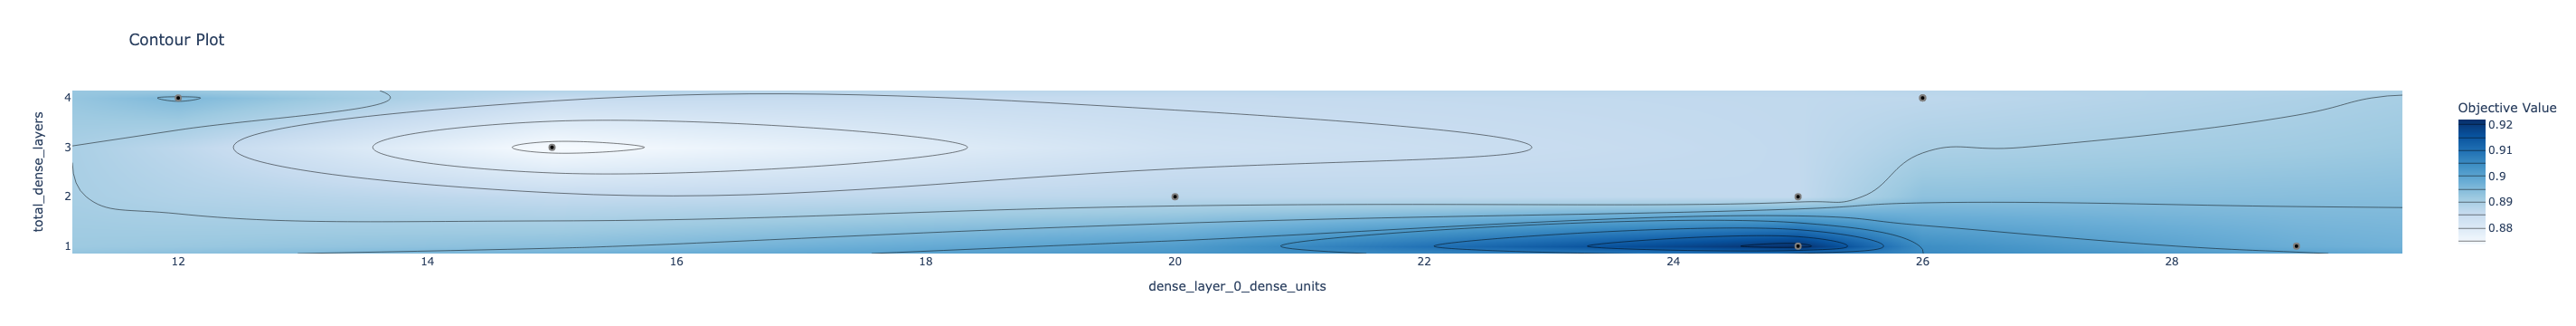

In [22]:
optuna.visualization.plot_contour(study, params=["total_dense_layers", "dense_layer_0_dense_units"])

In [23]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_layers (Sequential)    (None, 25)                38525     
_________________________________________________________________
dense (Dense)                (None, 8)                 208       
Total params: 10,822,268
Trainable params: 38,683
Non-trainable params: 10,783,585
_________________________________________________________________


## Post-train evaluation on saved model and study

Look at size of model

In [24]:
!ls saved_models/cnn_efficientnet -lah | grep _model.h5

-rw-r--r-- 1 root root  42M Nov 24 07:31 best_en_16k_model.h5
-rw-r--r-- 1 root root  43M Nov 27 00:51 best_en_16k_tuned_model.h5
-rw-r--r-- 1 root root  69M Nov 18 09:42 best_en_model.h5
-rw-r--r-- 1 root root  69M Nov 18 16:46 best_en_tuned_model.h5
-rw-r--r-- 1 root root  32M Nov 23 11:07 efficientnet0_16k_model.h5
-rw-r--r-- 1 root root  32M Nov 18 09:00 efficientnet0_model.h5


Look at "best_model" history

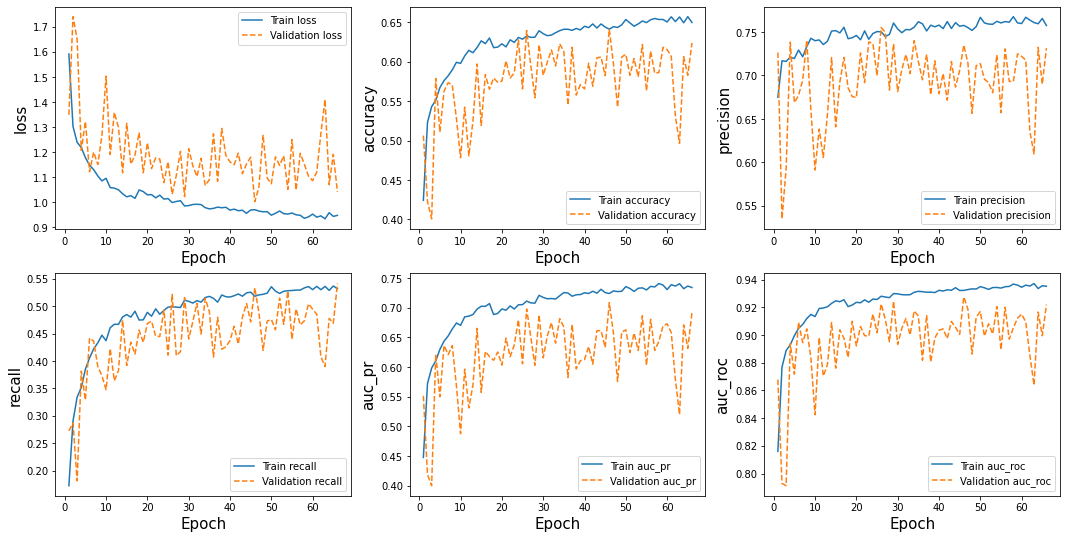

In [26]:
hist = pd.read_csv("saved_models/cnn_efficientnet/best_en_16k_tuned_model_history.csv")
plot_history_df(hist)

Thoughts: noise in validation data might be reduced with a bigger validation dataset (when we look at more than 2000 images).

Look at saved "best_model"

In [27]:
best_model = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_16k_tuned_model.h5")

In [28]:
best_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_layers (Sequential)    (None, 25)                38525     
_________________________________________________________________
dense (Dense)                (None, 8)                 208       
Total params: 10,822,268
Trainable params: 38,683
Non-trainable params: 10,783,585
_________________________________________________________________


In [ ]:
best_model.layers[1].summary()  # omit because it's lengthy

In [30]:
best_model.layers[2].summary()

Model: "dense_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 25)                38425     
_________________________________________________________________
dense_dropout_0 (Dropout)    (None, 25)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25)                100       
Total params: 38,525
Trainable params: 38,475
Non-trainable params: 50
_________________________________________________________________


### Using best model parameters for extended training and EfficientNet fine tuning

Unfreeze training for EfficientNet, train the whole thing for many epochs. The best version of post-hyperparameter-tuning model has only one dense layer with 25 units. Let's load that model.

In [42]:
# Recompile model with more metrics
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_16k_tuned_model.h5")

# Unfreeze EfficientNet layer
efficientnet_model = model.layers[1]
efficientnet_model.trainable = True

# Making the last X parameters trainable; others frozen/not trainable
target_trainable_params = 3e6  # the last 3 mil parameters (arbitrary)
trainable_params_left = target_trainable_params
for layer in reversed(efficientnet_model.layers):  # Go from bottom
    if trainable_params_left > 0:
        trainable_params_left -= layer.count_params()
        layer.trainable = True
    else:
        layer.trainable = False

# Compile to "lock it in"
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    metrics=metrics,
)

# Confirmation print of model structure
model.summary()
print("\n")
model.layers[2].summary()

callbacks = [CustomCallback(), tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=50, mode='max')]  # stop when not improving

print("Starting training:\n")
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0,
)
print("Done extended training")

# Save finetuned model
history_df = pd.DataFrame(history.history)
model.save("saved_models/cnn_efficientnet/best_en_16k_tuned_2x_model.h5")
history_df.to_csv("saved_models/cnn_efficientnet/best_en_16k_tuned_2x_model_history.csv")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_layers (Sequential)    (None, 25)                38525     
_________________________________________________________________
dense (Dense)                (None, 8)                 208       
Total params: 10,822,268
Trainable params: 3,411,835
Non-trainable params: 7,410,433
_________________________________________________________________


Model: "dense_layers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 25)                38425     
__________________

/usr/local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



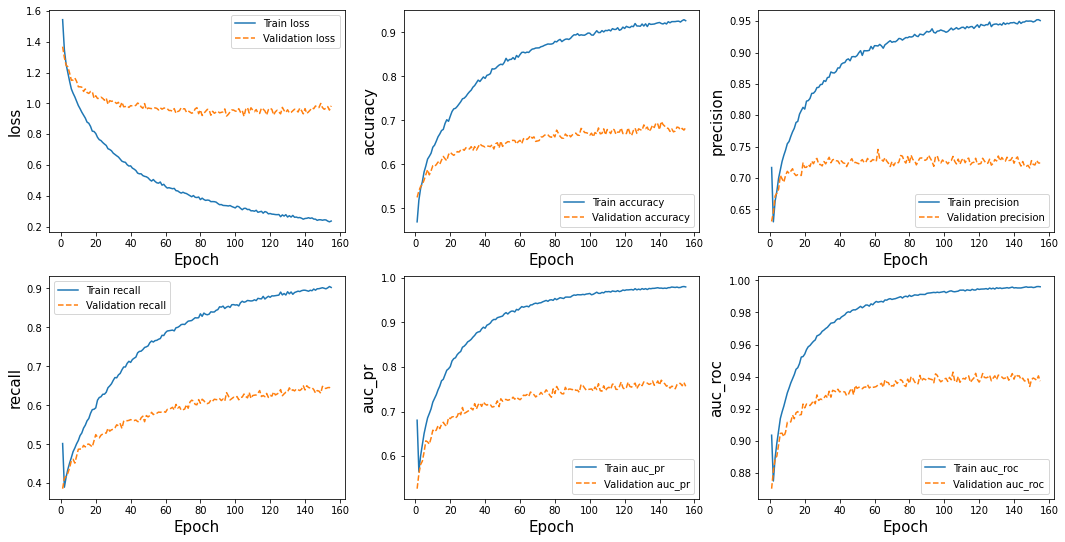

In [43]:
# History of EfficientNet fine-tuning
history_df = pd.read_csv("saved_models/cnn_efficientnet/best_en_16k_tuned_2x_model_history.csv")
plot_history_df(history_df)

In [44]:
# Final epoch metrics on EfficientNetB3 with one hidden layer (25 units)
history_df.tail(1)

,Unnamed: 0,loss,accuracy,precision,recall,auc_pr,auc_roc,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_auc_pr,val_auc_roc,val_f1_score
154,154,0.235652,0.9265,0.950919,0.902125,0.979367,0.996047,[0.9272773 0.9100632 0.90484387 0.9519497 0...,0.983859,0.683119,0.723772,0.640178,0.756667,0.937134,[0.47204965 0.72310406 0.4907749 0.26086956 0...


How does a hyperparameter-tuned model compare to the previous untuned, quickly-put-together model?

In [48]:
# Final epoch metrics on EfficientNetB0 with two hidden layers (10 units)
grand_history_df.tail(1)

,Unnamed: 0,loss,accuracy,precision,recall,auc_pr,auc_roc,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_auc_pr,val_auc_roc,val_f1_score
222,222,0.776854,0.726807,0.811089,0.605922,0.806498,0.957332,[0.6268908 0.77027327 0.55968106 0.8813814 0...,0.908037,0.681145,0.817483,0.576999,0.774674,0.93983,[0.4769231 0.75539565 0.43507588 0.2580645 0...


For some reason, the supposedly hyperparameter-tuned model performs OK comparably in validation data (compared to non-tuned EfficientNetB0) but has a bad case of overfitting.

As a compromise, I'll do the following:
- keep the Optuna-generated B3 model (1 hidden layer, 25 units)
- quick train a version of B3 using the B0 structure that worked at the beginning, compare results to original B0

In [5]:
IMG_SHAPE = (224, 224, 3)

# light augmentation on balanced data
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomFlip("vertical"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

tf.keras.backend.clear_session()
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights="imagenet",
    pooling="max",
    include_top=False,
)

# Making all of it not trainable
efficientnet_model.trainable = False


total_dense_layers = 2
dense_units = 10

dropout_rate = 0.1

dense_layers = tf.keras.models.Sequential(name="dense_layers")
for dense_layer_num in range(total_dense_layers):
    dense_layers.add(
        tf.keras.layers.Dense(
            dense_units,
            activation="relu",
            name=f"Dense_{dense_layer_num}",
        )
    )
    dense_layers.add(
        tf.keras.layers.Dropout(dropout_rate, name=f"dense_dropout_{dense_layer_num}")
    )
    dense_layers.add(
        tf.keras.layers.BatchNormalization()
    )

# putting it altogether
inputs = tf.keras.Input(shape=IMG_SHAPE)

x = data_augmentation(inputs)
x = efficientnet_model(x) # EfficientNet with ImageNet weights
x = dense_layers(x) # Dense layers

outputs = tf.keras.layers.Dense(8, activation="softmax")(x) # Classification layer

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_layers (Sequential)    (None, 10)                15560     
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 10,799,183
Trainable params: 15,608
Non-trainable params: 10,783,575
_________________________________________________________________


In [6]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

# Fit it - just dense layer
callbacks = [
    CustomCallback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=10, mode='max')
]
tf.keras.backend.clear_session()
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
history_1 = model.fit(
    train_ds,
    validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=0,
)
print("\ndone training")

Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-12-02 07:16:16.870 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:23910 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-12-02 07:16:16.894 tensorflow-2-6-gpu--ml-g4dn-xlarge-0dac2104acc07d6f4758a14ad24a:23910 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
**********|**********|**********|
done training


In [9]:
# Fine tuning
# Making the last 2 million parameters trainable; others frozen/not trainable
efficientnet_model.trainable = True

target_trainable_params = 2e6  # arbitrary
trainable_params_left = target_trainable_params
for layer in reversed(efficientnet_model.layers):  # Go from bottom
    if trainable_params_left > 0:
        trainable_params_left -= layer.count_params()
        layer.trainable = True
    else:
        layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
dense_layers (Sequential)    (None, 10)                15560     
_________________________________________________________________
dense (Dense)                (None, 8)                 88        
Total params: 10,799,183
Trainable params: 2,853,464
Non-trainable params: 7,945,719
_________________________________________________________________


In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    metrics=metrics,
)

# Fit it - just dense layer
callbacks = [
    CustomCallback(),
    tf.keras.callbacks.EarlyStopping(monitor='val_auc_roc', patience=50, mode='max')
]
tf.keras.backend.clear_session()
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
history_2 = model.fit(
    train_ds,
    validation_data=validation_ds,  # NOTE: validation data should be sourced from somewhere else, need to change
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=0,
)
print("\ndone training")

**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|**********|
done training


In [14]:
history_df = pd.concat([pd.DataFrame(history_1.history), pd.DataFrame(history_2.history)])
model.save("saved_models/cnn_efficientnet/efficientnet3_16k_model.h5")
history_df.to_csv("saved_models/cnn_efficientnet/efficientnet3_16k_model_history.csv")

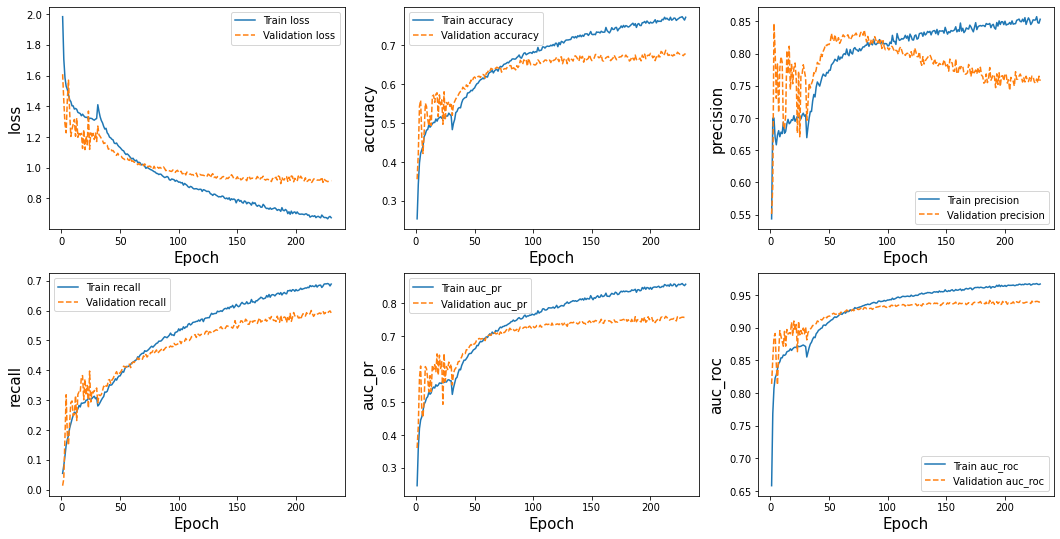

In [15]:
plot_history_df(history_df)

This is much more acceptable! However, the AUC-ROC is similar to B0, while the AUC-PR is slightly worse. We'll use B0 as our best model.

In [16]:
# Final epoch metrics on EfficientNetB3 with two hidden layers (10 units)
history_df.tail(1)

,loss,accuracy,precision,recall,auc_pr,auc_roc,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_auc_pr,val_auc_roc,val_f1_score
199,0.67461,0.771312,0.853194,0.688688,0.857172,0.966918,"[0.72505605, 0.7341201, 0.6776725, 0.87756044,...",0.915642,0.677196,0.757576,0.5923,0.754655,0.93964,"[0.49275362, 0.73704416, 0.5522388, 0.44444445..."


## Evaluation

In [26]:
random_seed = 21
test_ds = tf.keras.utils.image_dataset_from_directory(
    constants.get_testing_split_class_path(),
    seed=random_seed,
    image_size=(224, 224),  # chosen size based on what's common in industry
    batch_size=32,  # default
    label_mode='categorical',
    shuffle=True,  # default
)

# Load model from saved file
best_model = tf.keras.models.load_model("saved_models/cnn_efficientnet/efficientnet0_16k_modified_model.h5")

best_model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

Found 5066 files belonging to 8 classes.


In [27]:
results = best_model.evaluate(test_ds)

for n, v in zip(best_model.metrics_names, results):
    try:
        print(f"{n}\t: {v:.3f}")
    except:
        print(f"{n}\t: {v}")

159/159 [==============================] - 14s 66ms/step - loss: 1.2475 - accuracy: 0.5851 - precision: 0.8007 - recall: 0.3097 - auc_pr: 0.6232 - auc_roc: 0.9050 - f1_score: 0.4679
loss	: 1.248
accuracy	: 0.585
precision	: 0.801
recall	: 0.310
auc_pr	: 0.623
auc_roc	: 0.905
f1_score	: [0.3526682  0.6689758  0.41511562 0.21666667 0.39634144 0.77249926
 0.27459016 0.6459628 ]


In [28]:
test_preds = best_model.predict(test_ds)
test_preds_sparse = np.argmax(test_preds, axis=1)

labels_iterator=test_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels_dense = np.array(list(labels_iterator))
labels_sparse = np.argmax(labels_dense, axis=1)

labels=["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
labels_sorted = sorted(labels)

# Rearrange
sorted_to_real_idx = {labels_sorted.index(l): labels.index(l) for l in labels_sorted}
sorted_to_real_fn = lambda y_sorted: np.array([sorted_to_real_idx[i] for i in y_sorted])
y_true = sorted_to_real_fn(labels_sparse)
y_pred = sorted_to_real_fn(test_preds_sparse)

Classification Report
              precision    recall  f1-score   support

         MEL      0.204     0.147     0.171       895
          NV      0.511     0.430     0.467      2592
         BCC      0.136     0.151     0.143       684
          AK      0.026     0.025     0.025       160
         BKL      0.092     0.145     0.112       502
          DF      0.006     0.023     0.009        44
        VASC      0.000     0.000     0.000        47
         SCC      0.025     0.049     0.033       142

    accuracy                          0.283      5066
   macro avg      0.125     0.121     0.120      5066
weighted avg      0.326     0.283     0.301      5066

Accuracy: 0.2831
ROC AUC: 0.4891


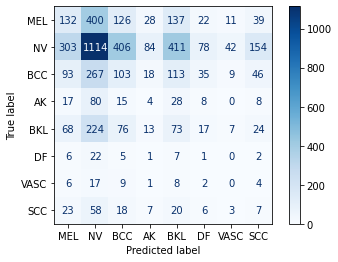

In [29]:
print ("Classification Report")
print(sklearn_metrics.classification_report(y_true, y_pred, labels=range(8), target_names=labels, digits=3))
print(f"Accuracy: {sklearn_metrics.accuracy_score(y_true, y_pred):.4f}")
#'ovr' Stands for One-vs-rest. Computes the AUC of each class against the rest
print(f"ROC AUC: {sklearn_metrics.roc_auc_score(labels_dense, test_preds, multi_class='ovr'):.4f}")

cm = sklearn_metrics.confusion_matrix(y_true, y_pred)
disp = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

We will also evaluate our seemingly overfitted model (B3, with hyperparameter tuning).

In [30]:
random_seed = 21
# test_ds = tf.keras.utils.image_dataset_from_directory(
#     constants.get_testing_split_class_path(),
#     seed=random_seed,
#     image_size=(224, 224),  # chosen size based on what's common in industry
#     batch_size=32,  # default
#     label_mode='categorical',
#     shuffle=True,  # default
# )

# Load model from saved file
best_model = tf.keras.models.load_model("saved_models/cnn_efficientnet/best_en_16k_tuned_2x_model.h5")

best_model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=metrics,
)

results = best_model.evaluate(test_ds)

for n, v in zip(best_model.metrics_names, results):
    try:
        print(f"{n}\t: {v:.3f}")
    except:
        print(f"{n}\t: {v}")

159/159 [==============================] - 23s 115ms/step - loss: 1.0324 - accuracy: 0.6700 - precision: 0.7472 - recall: 0.4422 - auc_pr: 0.6586 - auc_roc: 0.9123 - f1_score: 0.5123
loss	: 1.032
accuracy	: 0.670
precision	: 0.747
recall	: 0.442
auc_pr	: 0.659
auc_roc	: 0.912
f1_score	: [0.42302877 0.6878908  0.45049664 0.28735635 0.47959673 0.774245
 0.35367373 0.6423357 ]


In [31]:
test_preds = best_model.predict(test_ds)
test_preds_sparse = np.argmax(test_preds, axis=1)

labels_iterator=test_ds.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels_dense = np.array(list(labels_iterator))
labels_sparse = np.argmax(labels_dense, axis=1)

labels=["MEL", "NV", "BCC", "AK", "BKL", "DF", "VASC", "SCC"]
labels_sorted = sorted(labels)

# Rearrange
sorted_to_real_idx = {labels_sorted.index(l): labels.index(l) for l in labels_sorted}
sorted_to_real_fn = lambda y_sorted: np.array([sorted_to_real_idx[i] for i in y_sorted])
y_true = sorted_to_real_fn(labels_sparse)
y_pred = sorted_to_real_fn(test_preds_sparse)

Classification Report
              precision    recall  f1-score   support

         MEL      0.171     0.187     0.179       895
          NV      0.500     0.371     0.426      2592
         BCC      0.118     0.140     0.128       684
          AK      0.024     0.031     0.027       160
         BKL      0.092     0.155     0.116       502
          DF      0.000     0.000     0.000        44
        VASC      0.000     0.000     0.000        47
         SCC      0.052     0.063     0.057       142

    accuracy                          0.260      5066
   macro avg      0.120     0.118     0.117      5066
weighted avg      0.314     0.260     0.281      5066

Accuracy: 0.2598
ROC AUC: 0.4937


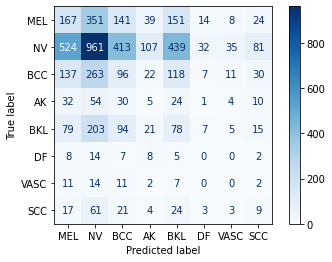

In [32]:
print ("Classification Report")
print(sklearn_metrics.classification_report(y_true, y_pred, labels=range(8), target_names=labels, digits=3))
print(f"Accuracy: {sklearn_metrics.accuracy_score(y_true, y_pred):.4f}")
#'ovr' Stands for One-vs-rest. Computes the AUC of each class against the rest
print(f"ROC AUC: {sklearn_metrics.roc_auc_score(labels_dense, test_preds, multi_class='ovr'):.4f}")

cm = sklearn_metrics.confusion_matrix(y_true, y_pred)
disp = sklearn_metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()